# Прогнозирование затрат на страхование жизни и здоровья

**Цель** — провести регрессионный анализ данных с целью построения моделей для прогнозирования затрат на страхование жизни и здоровья клиентов.


## Описание данных

|Признак|Описание|
|--:|:--|
|`age`|возраст клиента|
|`sex`|пол клиента|
|`bmi`|индекс массы тела|
|`children`|количество детей|
|`smoker`|курит или нет|
|`region`|регион проживания|
|`charges`|стоимость страхования|

## Примерный план

**Шаг 1.** Загрузка данных;

**Шаг 2.** Первичная обработка данных (при необходимости):
- скорректировать заголовки;
- скорректировать типы признаков;
- проверить наличие дублирующихся записей;
- проверить наличие аномальных значений;
- проверить пропущенные значения;

**Шаг 3.** Регрессионный анализ:
- преобразовать категориальные переменные в числовой вид;
- провести отбор независимых признаков для построения модели;
- провести построение и обучение модели;
- оценить качество модели;
- интерпретировать результаты анализа.


# Подключение библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# деление выборки на обучающую и тестовую
from sklearn.model_selection import train_test_split

# задание объекта LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor

#стандартизация и нормализация данных
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder


#метрики
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.svm import SVR



# Функции

In [2]:
def calc_boxplot(df_col : pd.Series) -> tuple:

    """
    Функция для расчета значений нижнего и верхнего усов.
    На вход подается столбец датафрейма,
    на выходе кортеж: первый элемент -- нижний ус, второй элемент -- верхний ус
    """

    Q1, median, Q3 = np.percentile(np.asarray(df_col.dropna()), [25, 50, 75])
    IQR = Q3 - Q1
    loval = Q1 - 1.5 * IQR
    hival = Q3 + 1.5 * IQR
    wiskhi = np.compress(np.asarray(df_col.dropna()) <= hival, np.asarray(df_col.dropna()))
    wisklo = np.compress(np.asarray(df_col.dropna()) >= loval, np.asarray(df_col.dropna()))
    actual_hival = np.max(wiskhi)
    actual_loval = np.min(wisklo)
    return actual_loval, actual_hival #(нижний ус, верхний ус)

# Загрузка и чтение данных

In [3]:
df = pd.read_csv('/content/sample_data/insurance.csv')

In [4]:
df.head(5)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [6]:
# просмотр описательных статистик

perc = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]

df.describe(percentiles=perc).T

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
age,1338.0,39.207025,14.049960,18.0000,18.00000,18.0000,27.00000,39.000,51.000000,62.000000,64.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,17.89515,21.2560,26.29625,30.400,34.693750,41.106000,46.407900,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,0.0000,0.00000,1.000,2.000000,3.000000,5.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,1252.97273,1757.7534,4740.28715,9382.033,16639.912515,41181.827787,48537.480726,63770.42801


# Предварительная обработка

## Поиск пропусков и дублей

In [7]:
# кол-во пропусков для признаков

df.isna().sum()

,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0


In [8]:
print(f'В анализируемом наборе {df.duplicated().sum()} дублей.')

В анализируемом наборе 1 дублей.


In [9]:
# удаление дублей
df.drop_duplicates(inplace=True)

## Поиск и обработка аномалий

In [10]:
# составим список непрерывных признаков
lst_var_cont = ['age', 'bmi', 'children', 'charges']

# для выявления аномальных значений признаков построим
# диаграмму "ящик с усами" и гистограмму

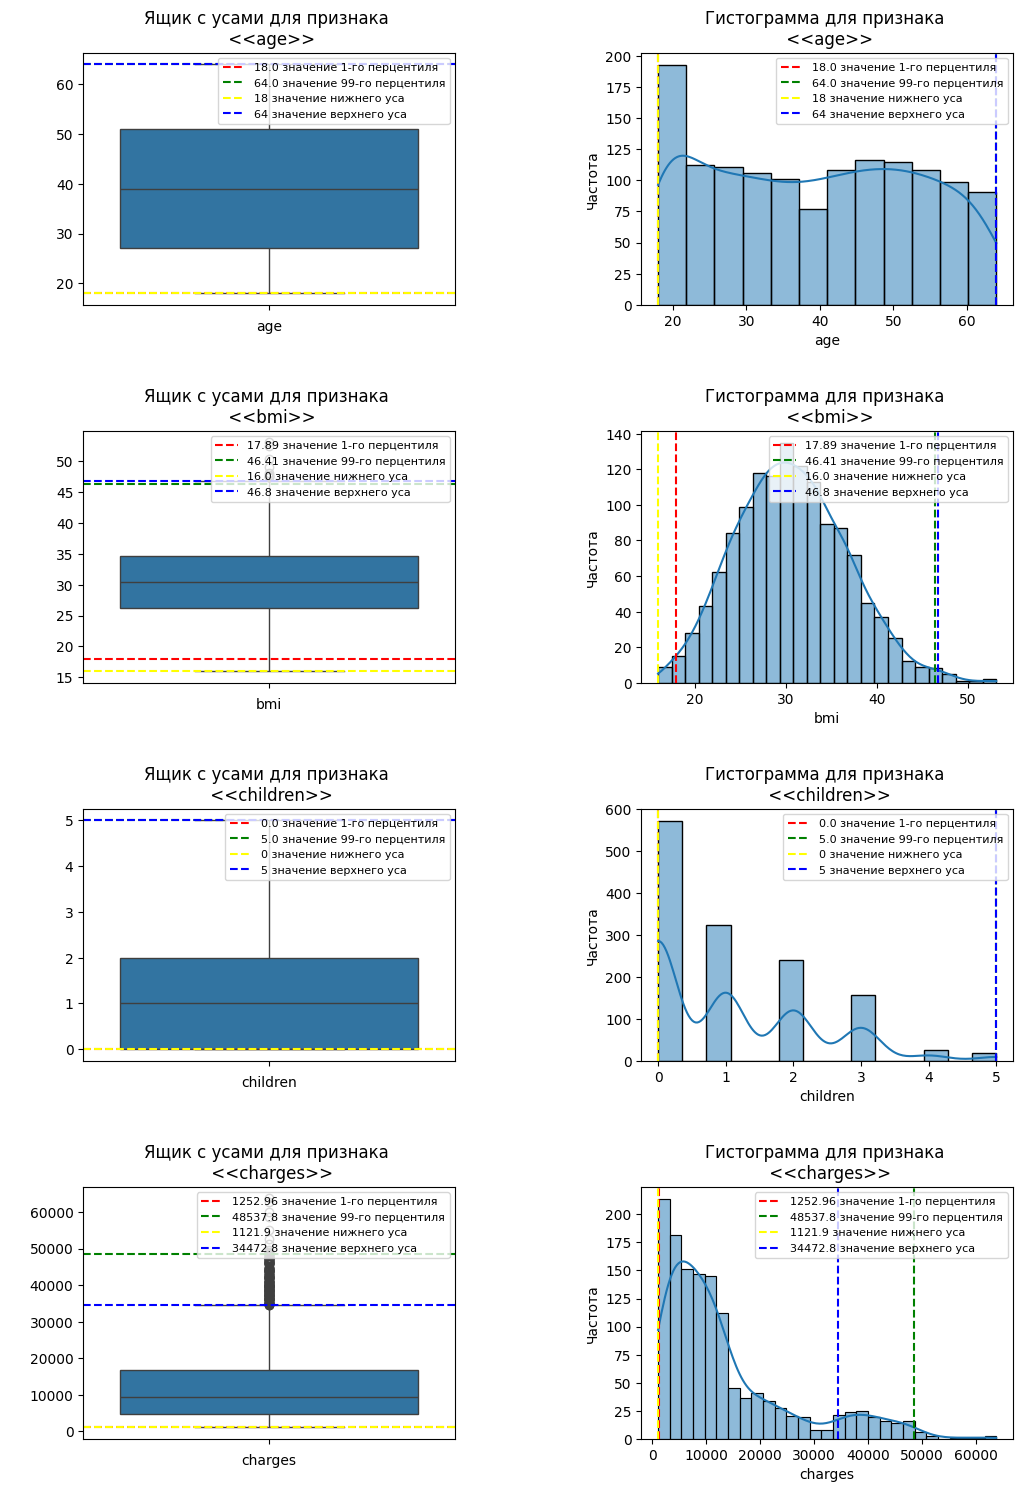

In [11]:
plt.subplots(4,2, figsize=(12,18), gridspec_kw={'wspace': 0.5,
                                                'hspace': 0.5})

for index, col in enumerate(lst_var_cont):

  per_1 = (np.nanpercentile(df[col], 1)).round(2)
  per_99 = (np.nanpercentile(df[col], 99)).round(2)
  low_wish, hi_wish = calc_boxplot(df[col])

  # boxplot
  plt.subplot(4,2, 2*index+1)
  ax1 = sns.boxplot(df[col]);
  plt.xlabel(f'{col}')
  plt.ylabel(' ')
  plt.title(f'Ящик с усами для признака \n <<{col}>>')

  # визуализация перцентелей
  ax1.axhline(per_1, color='red',
                      linestyle='dashed',
                      label=f'{per_1} значение 1-го перцентиля')
  ax1.axhline(per_99,
              color='green',
              linestyle='dashed',
              label=f'{per_99} значение 99-го перцентиля')

  # визуализация усов
  ax1.axhline(low_wish,
              color='yellow',
              linestyle='dashed',
              label=f'{np.round(low_wish,1)} значение нижнего уса')
  ax1.axhline(hi_wish,
              color='blue',
              linestyle='dashed',
              label=f'{np.round(hi_wish,1)} значение верхнего уса')
  plt.legend(fontsize=8, loc=1)


  # гистограмма
  plt.subplot(4,2, 2*index+2)
  ax2 = sns.histplot(df[col], kde=True)

  plt.title(f'Гистограмма для признака \n <<{col}>>')
  plt.xlabel(f'{col}')
  plt.ylabel('Частота')

  # визуализация перцентелей
  ax2.axvline(per_1, color='red',
                      linestyle='dashed',
                      label=f'{per_1} значение 1-го перцентиля')
  ax2.axvline(per_99,
              color='green',
              linestyle='dashed',
              label=f'{per_99} значение 99-го перцентиля')
  # визуализация усов
  ax2.axvline(low_wish,
              color='yellow',
              linestyle='dashed',
              label=f'{np.round(low_wish,1)} значение нижнего уса')
  ax2.axvline(hi_wish,
              color='blue',
              linestyle='dashed',
              label=f'{np.round(hi_wish,1)} значение верхнего уса')


  plt.legend(fontsize=8, loc=1)

In [12]:
# проанализировав построенные графики, составим фильтр для отсечения
# аномальный значений

filt = (
        (df['charges']
         .between(calc_boxplot(df['charges'])[0],
           (calc_boxplot(df['charges'])[1])
         )))
# очищенные данные
df_clear = df.loc[filt]
df_clear

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [13]:
# аномальные данные
df_anomals = df.loc[~filt]
df_anomals

,age,sex,bmi,children,smoker,region,charges
14,27,male,42.130,0,yes,southeast,39611.75770
19,30,male,35.300,0,yes,southwest,36837.46700
23,34,female,31.920,1,yes,northeast,37701.87680
29,31,male,36.300,2,yes,southwest,38711.00000
30,22,male,35.600,0,yes,southwest,35585.57600
...,...,...,...,...,...,...,...
1300,45,male,30.360,0,yes,southeast,62592.87309
1301,62,male,30.875,3,yes,northwest,46718.16325
1303,43,male,27.800,0,yes,southwest,37829.72420
1313,19,female,34.700,2,yes,southwest,36397.57600


In [14]:
# оценим процент потерь

print(f'% аномальных записей {(1 - df.loc[filt].shape[0]/df.shape[0]):.2%}')

% аномальных записей 10.40%


## Выводы

- были удалены дублирующиеся записи;
- при анализе аномальных значений выявлены выбросы по признаку `charges`. Если удалять все аномальные записи, то процент потерь составит 10. Принято решение не трогать эти данные, а строить модель с текущим набором.

# Регрессионный анализ

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.6+ KB


задача:

$$
charges = w_0 + w_1*age + w_2*sex + w_3*bmi + w_4*children + w_5*smoker + w_6*region
$$

здесь  $w_0, w_1, w_2,\ldots, w_6$ -- парараметры, подлежащие определению.

**Кодирование признаков**

In [16]:

le = LabelEncoder()
le.fit(df['smoker'])
df['smoker_num'] = le.transform(df['smoker'])
df.head(2)


,age,sex,bmi,children,smoker,region,charges,smoker_num
0,19,female,27.90,0,yes,southwest,16884.9240,1
1,18,male,33.77,1,no,southeast,1725.5523,0


In [17]:
le.fit(df['sex'])
df['sex_num'] = le.transform(df['sex'])
df.head()

,age,sex,bmi,children,smoker,region,charges,smoker_num,sex_num
0,19,female,27.900,0,yes,southwest,16884.92400,1,0
1,18,male,33.770,1,no,southeast,1725.55230,0,1
2,28,male,33.000,3,no,southeast,4449.46200,0,1
3,33,male,22.705,0,no,northwest,21984.47061,0,1
4,32,male,28.880,0,no,northwest,3866.85520,0,1


In [18]:
le.fit(df['region'])
df['region_num'] = le.transform(df['region'])
df.head()

,age,sex,bmi,children,smoker,region,charges,smoker_num,sex_num,region_num
0,19,female,27.900,0,yes,southwest,16884.92400,1,0,3
1,18,male,33.770,1,no,southeast,1725.55230,0,1,2
2,28,male,33.000,3,no,southeast,4449.46200,0,1,2
3,33,male,22.705,0,no,northwest,21984.47061,0,1,1
4,32,male,28.880,0,no,northwest,3866.85520,0,1,1


**Для выделения признаков и целевой переменной рассмотрим графики:**

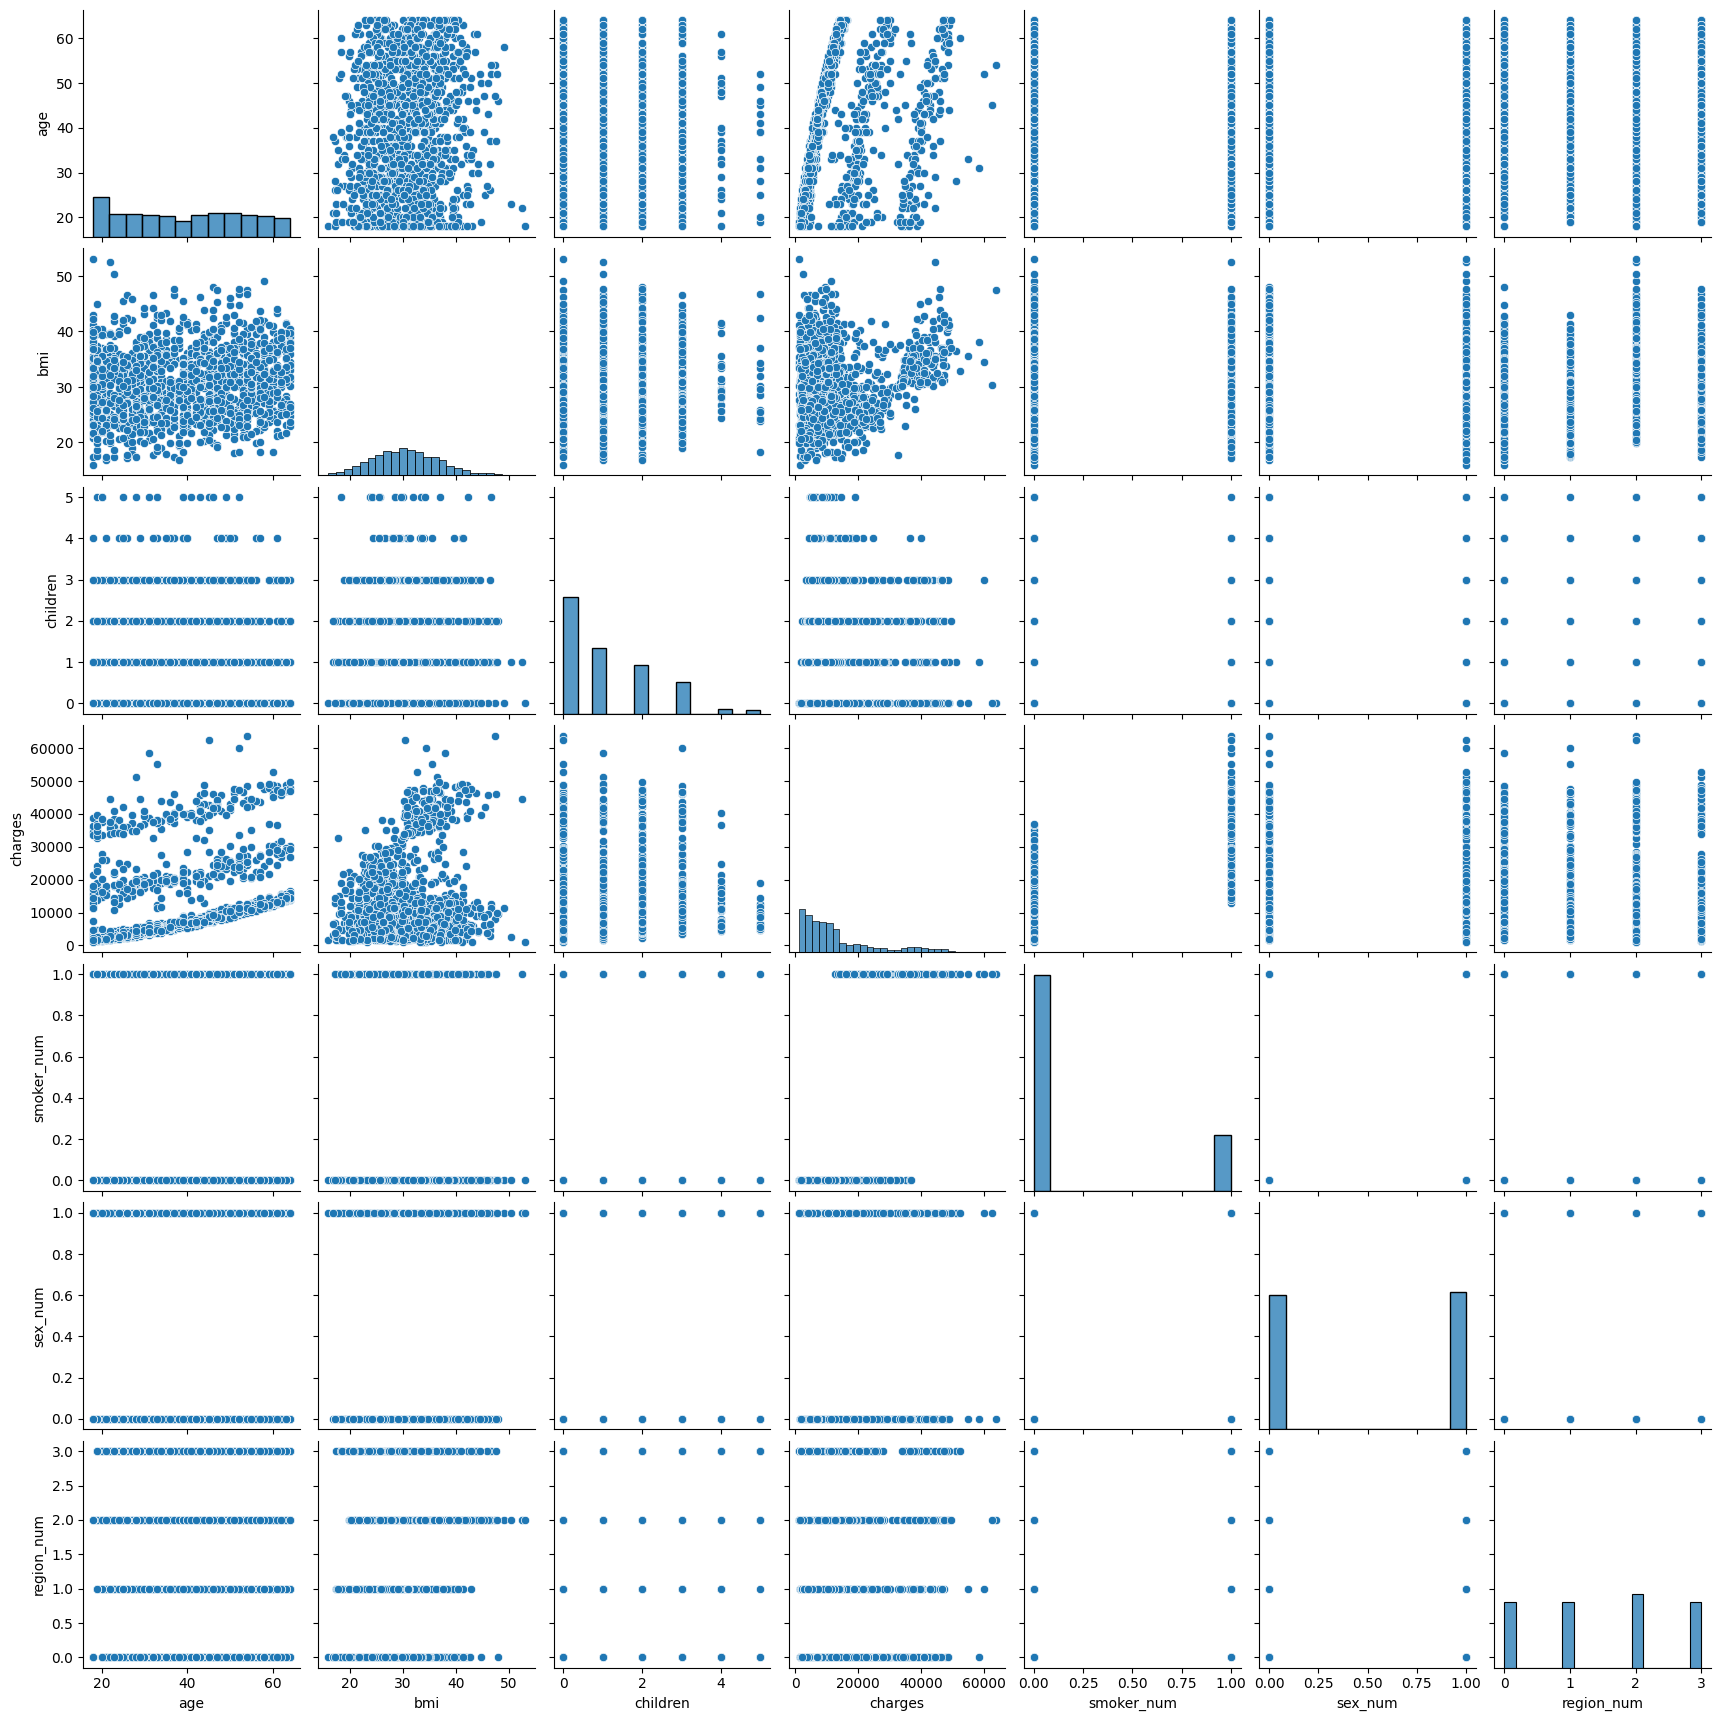

In [19]:
sns.pairplot(df)


In [20]:
# матрица корреляций
df[["charges", 'age', 'bmi', 'children', 'smoker_num', 'sex_num', 'region_num']].corr()


,charges,age,bmi,children,smoker_num,sex_num,region_num
charges,1.000000,0.298308,0.198401,0.067389,0.787234,0.058044,-0.006547
age,0.298308,1.000000,0.109344,0.041536,-0.025587,-0.019814,0.001626
bmi,0.198401,0.109344,1.000000,0.012755,0.003746,0.046397,0.157574
children,0.067389,0.041536,0.012755,1.000000,0.007331,0.017848,0.016258
smoker_num,0.787234,-0.025587,0.003746,0.007331,1.000000,0.076596,-0.002358
sex_num,0.058044,-0.019814,0.046397,0.017848,0.076596,1.000000,0.004936
region_num,-0.006547,0.001626,0.157574,0.016258,-0.002358,0.004936,1.000000


(7.5, -0.5)

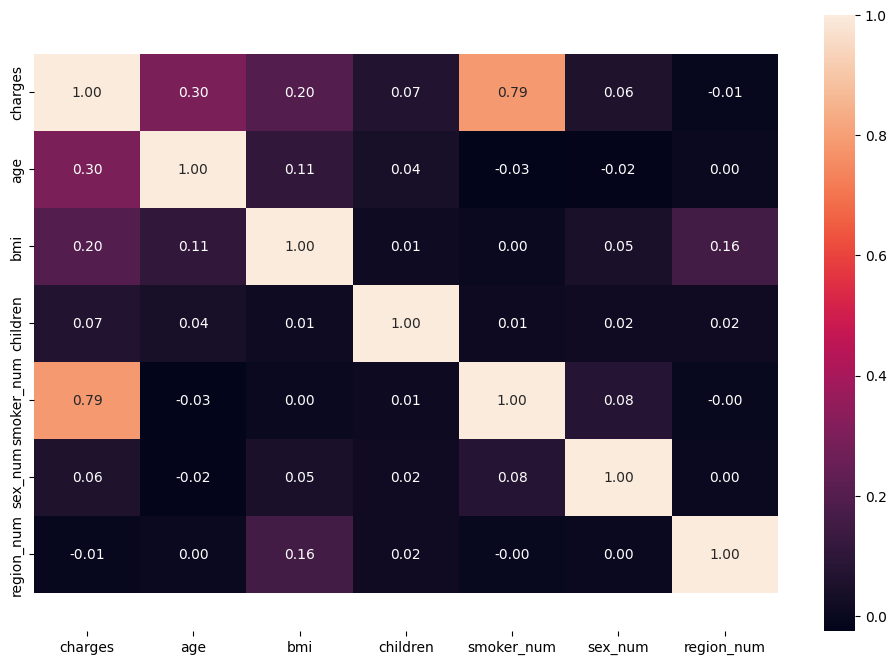

In [21]:
plt.figure(figsize = (12,8))
ax = sns.heatmap(df[["charges", 'age', 'bmi', 'children', 'smoker_num', 'sex_num', 'region_num']].corr(), annot = True, fmt = ".2f")
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5)

Видим, что наибольшее влияние на признак стоимость страховки оказывает
статус курильщика, затем возраст, индекс массы тела, кол-во детей.


**Сформируем множества**

In [22]:
y_col = ['charges']
x_col = ['bmi', 'age', 'children', 'smoker_num']

In [23]:
X = df[x_col]
y = df[y_col]

**Сделаем стандартизацию (приведем данные к одному масштабу)**

In [24]:
X_scal = StandardScaler().fit_transform(X)

**Разделим данные на тренировочные и тестовые (70% к 30%)**

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_scal, y,
        test_size = 0.3, random_state=0)
print(f"Размер тренировочного набора: {X_train.shape}")
print(f"Размер тестового набора: {X_test.shape}")

Размер тренировочного набора: (935, 4)
Размер тестового набора: (402, 4)


**Обучим модель линейной регрессии на тренировочных данных**

In [26]:
model = LinearRegression(fit_intercept = True)

model.fit(X_train, y_train)

LinearRegression()

**Сделаем предсказание на тестовой выборке**

In [27]:
y_pred = model.predict(X_test)
y_pred.shape

(402, 1)

In [28]:
df['charges'][100]

np.float64(6186.127)

In [29]:
y_pred[100]

array([12486.43683185])

**Оценка качества модели линейной регрессии**

In [30]:
y_test.shape

(402, 1)

In [31]:
model.predict(X_test).shape

(402, 1)

In [32]:
mse = mean_squared_error(y_test, model.predict(X_test))

print(f"Среднеквадратичная ошибка (MSE): {mse:.2f}")

Среднеквадратичная ошибка (MSE): 38837692.25


In [33]:
r2 = r2_score(y_test, y_pred)

print(f"Коэффициент детерминации (R^2): {r2:.2f}")

Коэффициент детерминации (R^2): 0.76


In [34]:
print(f'''Признаки и соответствующие коэффициенты
{X.columns,
model.coef_}''')
print()
print(f"Свободный член: {model.intercept_}")

Признаки и соответствующие коэффициенты 
(Index(['bmi', 'age', 'children', 'smoker_num'], dtype='object'), array([[1736.46547178, 3418.78712918,  562.26725408, 9545.30427756]]))

Свободный член: [13075.45544393]


Видим, что наибольшее влияние на результат оказывает признак `smoker_num` (статус курильщика), поскольку имеет максимальное по модулю значение.

In [35]:
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"Средняя абсолютная ошибка в процентах: {mape:.2f}")

Средняя абсолютная ошибка в процентах: 0.39


# Выводы

- в ходе анализа была проведена подготовка данных: очистка от дублей, кодирование категориальных переменных;
- по признаку `charges` были выявлены выбросы, но было принято решение их не трогать, так как процент потери большой (10%) в разрезе общего кол-ва записей;
- для выделения зависимой переменной и независимых переменных была построена матрица корреляций, таким образом отобраны следующие признаки:
  - `charges` - зависимая переменная,
  - `bmi`, `age`, `children`, `smoker_num` - независимые переменные, влияющие на целевую;

- данные были стандартизированы и разделены на тренировочные и тестовые в пропорциях 70/30;
- была обучена модель линейной регрессии на тренировочных данных, а на тестовых проведено прогнозирование;

- проведена оценка качества модели:
  - Среднеквадратичная ошибка (MSE): 38837692.25;
  - Коэффициент детерминации (R^2): 0.76 - качество модели можно считать хорошим;
  - Средняя абсолютная ошибка в процентах: 0.39 - указывает на разумные значения для прогнозирования;
  - Свободный член = 13075.45544393;
  - Коэффициенты по признакам, в порядке убывания:
     - `smoker_num` = 9545.30427756,
     - `age` = 3418.78712918,
     - `bmi` = 1736.46547178,
     - `children` = 562.26725408.

 Таким образом, определяющим фактором на формирование цены страховки клиента является, в первую очередь, статус курильщика (курит или нет), а затем уже возраст, индекс массы тела и наличие детей.